# Strating with a Simple Example: Digits Data from sklearn
Let's start our adventure into convolutional networks with a simple example of the digits dataset. This was not always such a simple example, but modern day computing power and open source tools has made it a significantly more tractable problem. 

In [17]:

from sklearn import datasets as ds
import pandas as pd
import numpy as np
import os, os.path
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.pyplot as plt
import colorsys
import copy
from PIL import Image

from sklearn.decomposition import KernelPCA
import zipfile

import skimage
from skimage import io

from skimage.transform import resize
from random import shuffle
import seaborn as sns

from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
import numpy as np

import re


# define X and y here.
import glob2
from PIL import Image
import matplotlib.image as mpimg




In [9]:
image_data = []
image_labels = []

directory = "./train"
os.walk(directory)
folder_names = [x[0] for x in os.walk(directory)]
del folder_names[0]
print(folder_names)
categories = {category.replace('./train\\', '') for category in folder_names}
print(categories)

['./train\\ALB', './train\\BET', './train\\DOL', './train\\LAG', './train\\NoF', './train\\OTHER', './train\\SHARK', './train\\YFT']
{'OTHER', 'LAG', 'SHARK', 'DOL', 'NoF', 'ALB', 'YFT', 'BET'}


In [35]:
%time
fish_image_files = glob2.glob('train/**/*.jpg')
size = 300, 300
# Also need to get labels from the filename and associate with each image. Just a parallele numpy array with target classes would be good.

# for folder in train
# folder is the y
# for file in folder
# file is the x
igs = np.array([skimage.transform.resize(skimage.io.imread(fname, as_grey=True, plugin=None, flatten=None),(300,300))
                                         for fname in fish_image_files])
# Print variable fname and see if the string contains path which indicates the target function


Wall time: 0 ns
train\ALB\img_00003.jpg
train\ALB\img_00010.jpg
train\ALB\img_00012.jpg
train\ALB\img_00015.jpg
train\ALB\img_00019.jpg
train\ALB\img_00020.jpg
train\ALB\img_00029.jpg
train\ALB\img_00032.jpg
train\ALB\img_00037.jpg
train\ALB\img_00038.jpg
train\ALB\img_00039.jpg
train\ALB\img_00041.jpg
train\ALB\img_00043.jpg
train\ALB\img_00045.jpg
train\ALB\img_00055.jpg
train\ALB\img_00057.jpg
train\ALB\img_00074.jpg
train\ALB\img_00085.jpg
train\ALB\img_00090.jpg
train\ALB\img_00097.jpg
train\ALB\img_00110.jpg
train\ALB\img_00121.jpg
train\ALB\img_00130.jpg
train\ALB\img_00134.jpg
train\ALB\img_00136.jpg
train\ALB\img_00154.jpg
train\ALB\img_00156.jpg
train\ALB\img_00163.jpg
train\ALB\img_00177.jpg
train\ALB\img_00186.jpg
train\ALB\img_00187.jpg
train\ALB\img_00188.jpg
train\ALB\img_00191.jpg
train\ALB\img_00193.jpg
train\ALB\img_00197.jpg
train\ALB\img_00201.jpg
train\ALB\img_00206.jpg
train\ALB\img_00208.jpg
train\ALB\img_00209.jpg
train\ALB\img_00211.jpg
train\ALB\img_00215.jpg


In [41]:
image_labels = []
for fname in fish_image_files:
    image_labels.append(re.sub('img.*', '', fname.replace('train\\', '')))


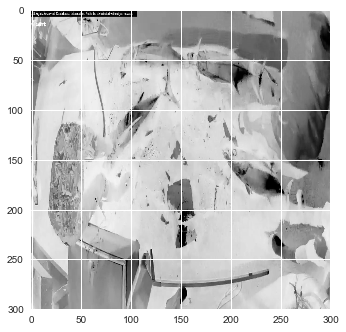

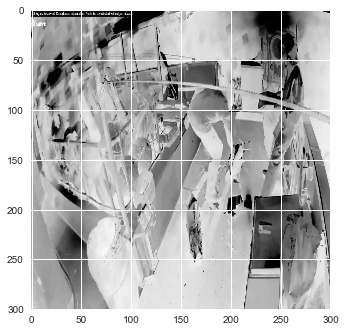

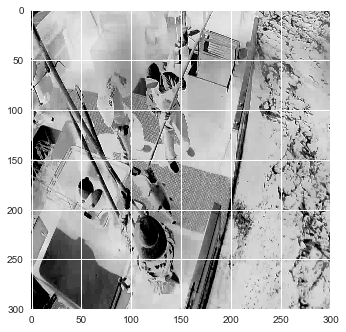

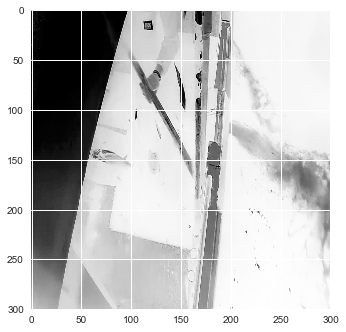

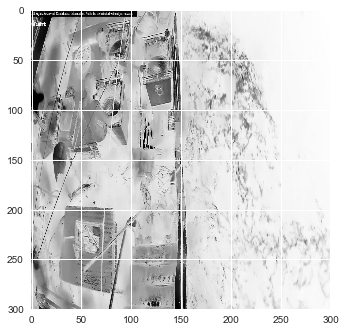

In [36]:
for i in range(0,5):
    plt.imshow(igs[i])
    plt.show()

In [47]:
#train_data = igs.astype('float32')
#train_data = train_data / 255
#igs_pca = train_data.reshape(igs.shape[0], (train_data.shape[1]*train_data.shape[2]))
X = igs
y = np.asarray(image_labels)
print(len(X), len(y))

3777 3777


In [48]:
# Split it into train / test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Split X_train again to create validation data
#X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2)

X_train.shape

(3021, 300, 300)

In [56]:
print(y_train.shape)

(3021,)


'YFT\\'

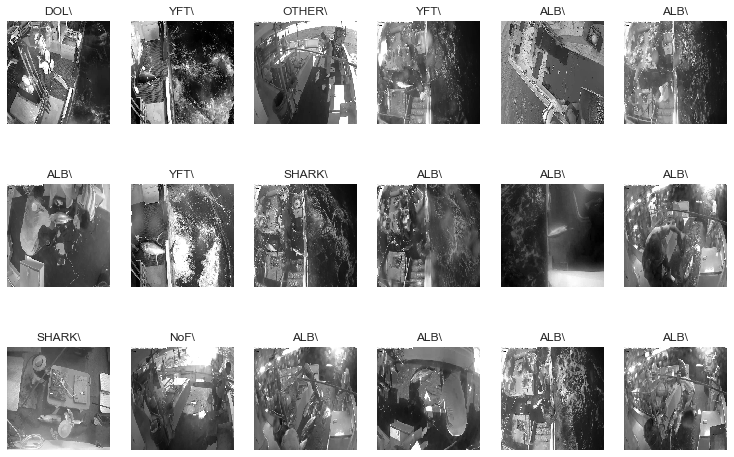

In [57]:
# What do these images look like?
from matplotlib import pyplot as plt
%matplotlib inline

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_train, y_train, 8, 8) # defaults to showing a 3 by 6 subset of the images

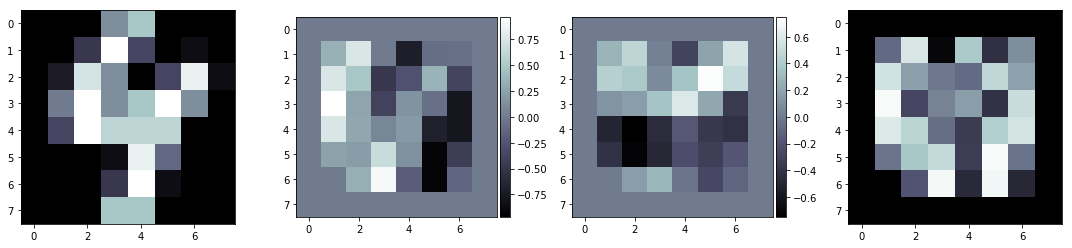

In [3]:
# A reminder of what convolution is
from skimage.io import imshow
from skimage.filters import sobel_h, sobel_v

plt.figure(figsize=(15,4))

idx_to_reconstruct = int(np.random.rand(1)*len(X))
img  = X[idx_to_reconstruct].reshape((8,8))

plt.subplot(1,4,1)
imshow(img,cmap='bone')

sv = sobel_v(img)
sh = sobel_h(img)

plt.subplot(1,4,2)
imshow(sv,cmap='bone')
plt.subplot(1,4,3)
imshow(sh,cmap='bone')

gradient_mag = np.sqrt(sv**2 + sh**2 ) 
plt.subplot(1,4,4)
imshow(gradient_mag,cmap='bone')


The above shows two separate convolutions of one digit using sobel filters (essentially vertical and horizontal edge detectors, derivative). The far image is the combined magnitudes of the sobel filters. Wouldn't it be great if we did not need to specify the correct filters? What if we could just let the weights of the convolution be found through neural netowrk training methods. 

Of course, we can. Let's do one example with a simple CNN architecture and compare it to the performance of a pixel wise MLP.

____
# A very Simple ConvNet Versus a Raw Pixel Input MLP
In general, the flattened images placed through a MLP can be quite accurate (as we have seen in the past). Even so, using convolitional filters and pooling should provide us with some better resilience to small perturbations in the images. 

In [4]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

keras.__version__

Using TensorFlow backend.


'2.0.2'

In [5]:
NUM_CLASSES = 10
print(X_train.shape)
print(X_test.shape)

(1437, 64)
(360, 64)


In [40]:
%%time

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Dense(input_dim=X_train.shape[1], units=30, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

CPU times: user 13.4 s, sys: 6.29 s, total: 19.6 s
Wall time: 13.2 s


In [41]:
%%time

# make a CNN with conv layer and max pooling
cnn = Sequential()
cnn.add(Reshape((1,8,8), input_shape=(1,64)))
cnn.add(Conv2D(filters=16, kernel_size= (2, 2), padding='same', input_shape=(1,8,8)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
# add one layer on flattened output
cnn.add(Flatten())
cnn.add(Dense(NUM_CLASSES))
cnn.add(Activation('softmax'))

# Let's train the model 
cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

CPU times: user 18.9 s, sys: 8.62 s, total: 27.5 s
Wall time: 17.6 s


In [62]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))

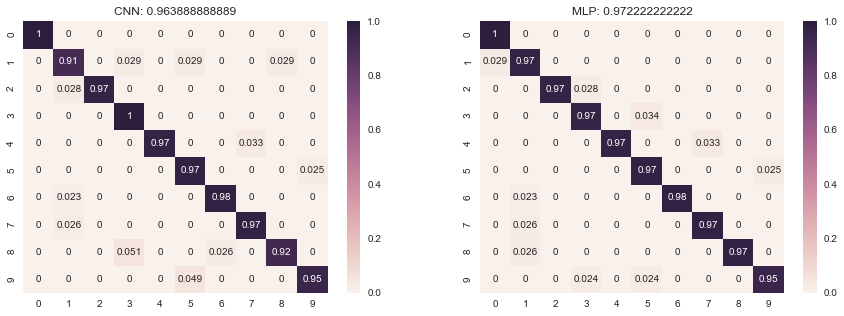

In [43]:
compare_mlp_cnn(cnn,mlp,X_test,y_test)

CPU times: user 26.9 s, sys: 8.5 s, total: 35.4 s
Wall time: 24.4 s


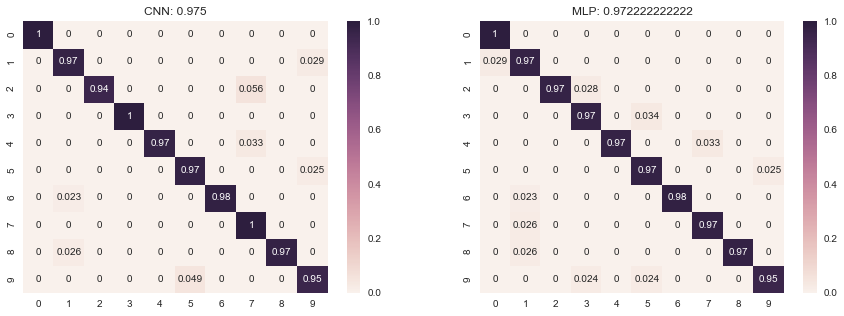

In [46]:
%%time

# changes: 
#    1. increased kernel size
cnn2 = Sequential()
cnn2.add(Reshape((1,8,8), input_shape=(1,64)))
cnn2.add(Conv2D(filters=16, kernel_size= (3, 3), padding='same', input_shape=(1,8,8)))
cnn2.add(Activation('relu'))
cnn2.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
# add one layer on flattened output
cnn2.add(Flatten())
cnn2.add(Dense(NUM_CLASSES))
cnn2.add(Activation('softmax'))

# Let's train the model 
cnn2.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn2.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

compare_mlp_cnn(cnn2,mlp,X_test,y_test)

CPU times: user 43 s, sys: 10.1 s, total: 53.1 s
Wall time: 30.1 s


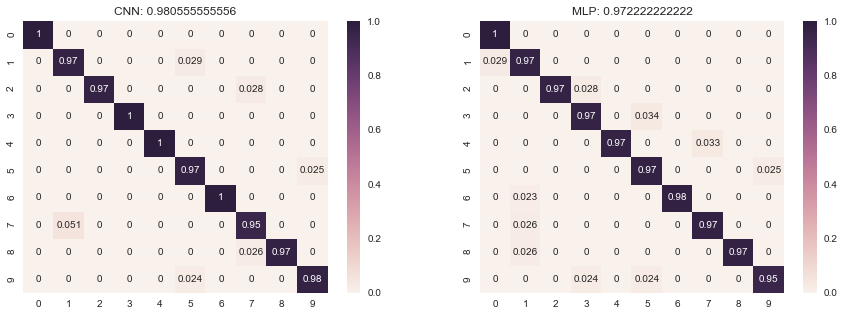

In [47]:
%%time

# changes: 
#    1. increased kernel size
#    2. add another conv/pool layer 
cnn3 = Sequential()
cnn3.add(Reshape((1,8,8), input_shape=(1,64)))

num_filt_layers = [32, 32]
for num_filters in num_filt_layers:
    cnn3.add(Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same'))
    cnn3.add(Activation('relu'))
    cnn3.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    

# add one layer on flattened output
cnn3.add(Flatten())
cnn3.add(Dense(NUM_CLASSES))
cnn3.add(Activation('softmax'))

# Let's train the model 
cnn3.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn3.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

compare_mlp_cnn(cnn3,mlp,X_test,y_test)

CPU times: user 23.5 s, sys: 4.43 s, total: 27.9 s
Wall time: 14.4 s


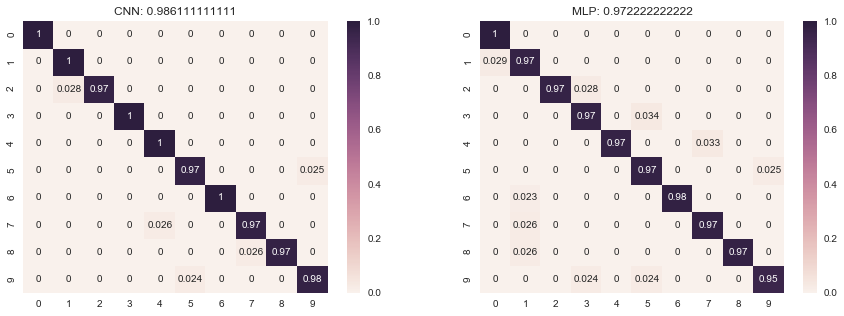

In [52]:
%%time

# changes: 
#    1. increased kernel size
#    2. add another conv/pool layer with increasing num filters
#    3. add more layers once flattened
cnn4 = Sequential()
cnn4.add(Reshape((1,8,8), input_shape=(1,64)))

num_filt_layers = [24, 48]
for num_filters in num_filt_layers:
    cnn4.add(Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same'))
    cnn4.add(Activation('relu'))
    cnn4.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    

# add one layer on flattened output
cnn4.add(Flatten())
cnn4.add(Dense(100))
cnn4.add(Activation('relu'))
cnn4.add(Dense(NUM_CLASSES))
cnn4.add(Activation('softmax'))

# Let's train the model 
cnn4.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn4.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=64, epochs=100, 
        shuffle=True, verbose=0)

compare_mlp_cnn(cnn4,mlp,X_test,y_test)

# MNIST
Okay, so we are honing in on the best performance for the digits data. But, we really need something a bit bigger to work on. Enter: MNIST. We have already used this dataset in the past, where we got about 97% accuracy with our custom MLP. Lets see how well Keras and tensorflow can perform!

In [54]:
# more data for handwriting recognition?
# Let's use Raschka's implementation for using the mnist dataset:
# https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
import os
import struct
import numpy as np
# from sklearn.preprocessing import RobustScaler
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
 
    return images.astype(np.float32), labels.reshape((-1,1)).astype(np.int32)

X_train, y_train = load_mnist('data/', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('data/', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

X_train = X_train/255.0
X_test = X_test/255.0

NUM_CLASSES = 10

y_train.shape

Rows: 60000, columns: 784
Rows: 10000, columns: 784


(60000, 1)

In [55]:
%%time

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

# make a keras MLP
mlp = Sequential()
mlp.add( Dense(input_dim=X_train.shape[1], units=100, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=15, 
        shuffle=True, verbose=1)

Epoch 1/15
60000/60000 [==============================] - 7s - loss: 0.2555 - acc: 0.9243       

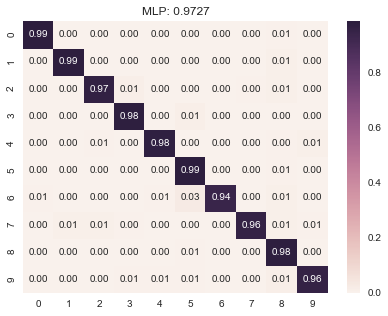

In [63]:
compare_mlp_cnn(None,mlp,X_test,y_test)

Epoch 1/15
60000/60000 [==============================] - 17s - loss: 0.0159 - acc: 0.8912      

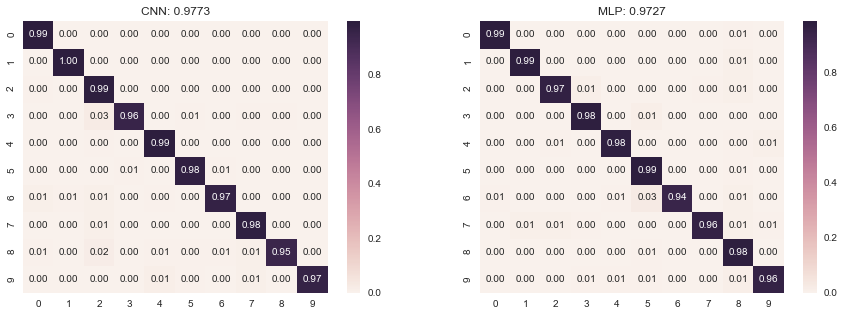

In [65]:
%%time

img_wh = 28 # width and height of MNIST images

# changes: 
#    1. Baseline: 2 conv layers and two output layers
cnn1 = Sequential()
cnn1.add(Reshape((1,img_wh, img_wh), input_shape=(1,img_wh**2)))

num_filt_layers = [24, 24]
for num_filters in num_filt_layers:
    cnn1.add(Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same'))
    cnn1.add(Activation('relu'))
    cnn1.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    

# add one layer on flattened output
cnn1.add(Flatten())
cnn1.add(Dense(100, activation='relu'))
cnn1.add(Dense(100, activation='relu'))
cnn1.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn1.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn1.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=32, epochs=15, 
        shuffle=True, verbose=1)

compare_mlp_cnn(cnn1,mlp,X_test,y_test)

In [84]:
%%time
# Copy TensorFlow Architecture from 
#   Deep MNIST for experts
#   https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html

# Manipulated to mirror parts of this network:
#   http://ankivil.com/mnist-database-and-simple-classification-networks/

cnn2 = Sequential()
cnn2.add(Reshape((1,img_wh, img_wh), input_shape=(1,img_wh**2)))

num_filt_layers = [32, 64]
for num_filters in num_filt_layers:
    cnn2.add(Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same', 
                    activation='relu')) # more compact syntax

    # max pooling
    cnn2.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))
    

# add one layer on flattened output
cnn2.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn2.add(Flatten())
cnn2.add(Dense(1024, activation='relu'))
cnn2.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn2.add(Dense(NUM_CLASSES, activation='softmax'))

# Let's train the model 
cnn2.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn2.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=128, epochs=11, 
        shuffle=True, verbose=1,
        validation_data=(np.expand_dims(X_test, axis=1),y_test_ohe))



Train on 60000 samples, validate on 10000 samples
Epoch 1/11
60000/60000 [==============================] - 21s - loss: 0.4158 - acc: 0.8683 - val_loss: 0.1178 - val_acc: 0.9631

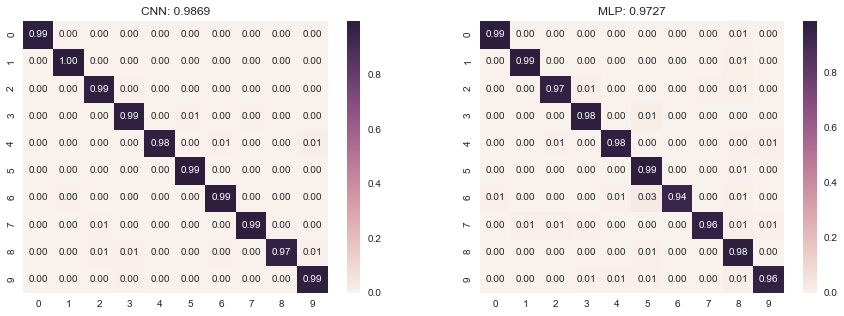

In [85]:
compare_mlp_cnn(cnn2,mlp,X_test,y_test)

In [86]:
cnn2.evaluate(np.expand_dims(X_test, axis=1),y_test_ohe)

 9952/10000 [============================>.] - ETA: 0s

[0.04149025030447228, 0.9869]

In [104]:
# want to save this model for later?
cnn2.save('large_data/mnist_cnn.h5')

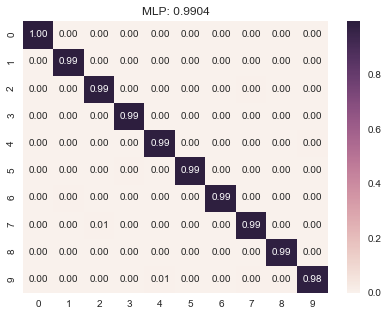

In [105]:
from keras.models import load_model

cnn_mnist = load_model('large_data/mnist_cnn.h5')
compare_mlp_cnn(None,cnn_mnist,np.expand_dims(X_test.reshape((-1,img_wh,img_wh)), axis=3),y_test)

In [43]:
# This hangs the processor using the contrib library with tensorflow.
# I have not been able to debug it quite yet
# %%time

# NUM_CLASSES = 10
# def conv_model(features, targets, mode):
#     print('===============================')
#     print(features)
#     # get in format expected by conv2d
#     # (batch_size,width, height,color_channels)
#     # since our images are gray scale and 8x8 pixels
#     #   we define the last three elements as 8x8x1
#     # we don't know the batch size, so just let it 
#     # figure that out from the input data (-1 designation)
#     features = tf.reshape(features, [-1, 8, 8, 1])
#     print(features)
    
#     # now lets define the convolution
#     # here we are saying to find 24 different filter outputs from the image
#     # using a 3x3 weight kernel
# #     features = layers.conv2d(inputs=features, 
# #                              num_outputs=4, 
# #                              kernel_size=[2, 2])
#     features = tf.layers.conv2d(
#         inputs=features,
#         filters=4,
#         kernel_size=[2, 2],
#         padding="same",
#         activation=tf.nn.relu)
#     print(features)
    
#     # take the max of each of the 24 filter outputs (lose spatial resolution)
# #     features = tf.reduce_max(input_tensor=features, 
# #                              reduction_indices=[1, 2])
#     features = tf.layers.max_pooling2d(inputs=features, pool_size=[2, 2], strides=[2, 2])
    
#     print(features)
    
#     features = layers.flatten(features)
#     print(features)
    
#     # now pass the features through a fully connected layer
#     predictions = tf.layers.dense(inputs=layers.bias_add(features), units=NUM_CLASSES ) #, activation=tf.nn.softmax)
#     #predictions = layers.fully_connected(layers.bias_add(features), num_outputs=NUM_CLASSES) # the number of classes to predict 
#     # and pass them through a sigmoid activation
#     #predictions = tf.sigmoid(predictions) 
#     print(predictions)
    
#     loss = None
#     train_op = None
    
#     # =====LOSS=======
    
#     # Calculate Loss (for both TRAIN and EVAL modes)
#     if mode != learn.ModeKeys.INFER:
#         onehot_labels = tf.one_hot(indices=tf.cast(targets, tf.int32), depth=NUM_CLASSES)
#         loss = tf.losses.softmax_cross_entropy(
#             onehot_labels=onehot_labels, logits=predictions)

#     # Configure the Training Op (for TRAIN mode)
#     if mode == learn.ModeKeys.TRAIN:
#         train_op = tf.contrib.layers.optimize_loss(
#             loss=loss,
#             global_step=tf.contrib.framework.get_global_step(),
#             learning_rate=0.001,
#             optimizer="SGD")

# #     # we want to use cross entropy as loss
# #     #loss = tf.losses.mean_squared_error(onehot_labels, predictions)
# #     loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits=predictions)
# # #     loss = tf.losses.sigmoid_cross_entropy(targets, predictions) 
    
#     # =====OPTIMIZER PARAMS========
#     # now let's setup how we want thing to optimize 
# #     train_op = layers.optimize_loss(
# #         loss=loss, 
# #         global_step=tf.contrib.framework.get_global_step(),
# #         optimizer='SGD', # adaptive gradient, so that the learning rate is not SO important
# #         learning_rate=0.01)
    
#     # what format to have the output in when calling clf.predict?
#     predictions_out = tf.argmax(predictions, dimension=1)
    
#     return model_fn_lib.ModelFnOps(
#       mode=mode, predictions=predictions_out, loss=loss, train_op=train_op)


# # Create a classifier, train and predict.
# cnn = learn.Estimator(model_fn=conv_model)
# cnn.fit(X_train, y_train, steps=10 )
# # cnn = learn.TensorFlowEstimator(model_fn=conv_model, 
# #                                        n_classes=10, steps=1000, 
# #                                        learning_rate=0.05, batch_size=128)

# cnn.fit(X_train, y_train)


In [ ]:
# # And even older syntax:

# def conv_model(X, y):
#     print('===============================')
#     print(X)
#     # get in format expected by conv2d
#     # (batch_size,width, height,color_channels)
#     # since our images are gray scale and 28x28 pixels
#     #   we define the last three elements as 28x28x1
#     # we don't know the batch size, so just let it 
#     # figure that out from the input data (-1 designation)
#     img_wh = 28 # height and width of images
#     features = tf.reshape(X, [-1, img_wh, img_wh, 1])
#     print(features)
    
#     # create 32 filters of 5x5 size 
#     n_out = 32
#     kernel = [5,5]
#     features = layers.conv2d(inputs=features, 
#                             num_outputs=n_out, 
#                             kernel_size=kernel)
    
#     # add a bias and pass through relu (for concentrated gradients)
#     features = tf.nn.relu(layers.bias_add(features))
    
#     # 2x2 max pool to reduce image size to 14x14
#     kernel = [1, 2, 2, 1]
#     stride = [1, 2, 2, 1]
#     features = tf.nn.max_pool(features, ksize=kernel,strides=stride, padding='SAME')
    
#     # create 64 filters of 5x5 size
#     n_out = 64
#     kernel = [5,5]
#     features = layers.conv2d(inputs=features, 
#                             num_outputs=n_out, 
#                             kernel_size=kernel)
    
#     # add a bias and pass through relu (for concentrated gradients)
#     features = tf.nn.relu(layers.bias_add(features))
    
#     # 2x2 max pool to reduce image size to 7x7
#     kernel = [1, 2, 2, 1]
#     stride = [1, 2, 2, 1]
#     features = tf.nn.max_pool(features, ksize=kernel,strides=stride, padding='SAME')
    

#     # make the weights a column vector, 7x7x64 = 3136
#     features = layers.flatten(features)
#     print(features)
    
#     # pass through fully connected layer with 1024 hidden neurons, W=3136x1024
#     features = layers.stack(features, layers.fully_connected, [1024])
    
#     # add bias and pass through relu
#     features = tf.nn.relu(layers.bias_add(features))
#     print(features)
    
#     # then make a fully connected layer with bias and sigmoid nonlinearity 
#     #  which... is... just logistic regression with one versus all
#     pred, loss = learn.models.logistic_regression(features, y)
#     print(pred)
    
#     print('===============================')
    
#     return pred, loss


# # Create a classifier, train and predict.
# classifier = learn.TensorFlowEstimator(model_fn=conv_model, 
#                                        n_classes=10, steps=20000, 
#                                        learning_rate=0.05, batch_size=64)

# # this operation can take a little while to complete
# #   Google says it should take about 30 minutes, but 
# #   my machine took a lot longer...
# classifier.fit(X_train, y_train)

# # now predict the outcome
# score = accuracy_score(y_test, classifier.predict(X_test))
# print(score)

In [ ]:
# ===============================
# Tensor("input:0", shape=(?, 784), dtype=float32)
# Tensor("Reshape:0", shape=(?, 28, 28, 1), dtype=float32)
# Tensor("Flatten/Reshape:0", shape=(?, 3136), dtype=float32)
# Tensor("Relu_2:0", shape=(?, 1024), dtype=float32)
# Tensor("logistic_regression/softmax_classifier/Softmax:0", shape=(?, 10), dtype=float32)
# ===============================
# 0.9926
# CPU times: user 4h 1min 13s, sys: 31min 8s, total: 4h 32min 21s
# Wall time: 1h 31min 33s